In [1]:
!pip install -qq transformers sentence_transformers datasets py3nvml

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 78 kB 5.7 MB/s 
     |████████████████████████████████| 290 kB 36.3 MB/s 
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
     |████████████████████████████████| 596 kB 47.9 MB/s 
     |████████████████████████████████| 3.3 MB 35.3 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 132 kB 50.1 MB/s 
     |████████████████████████████████| 243 kB 49.1 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 271 kB 51.7 MB/s 
     |████████████████████████████████| 192 kB 50.7 MB/s 
     |████████████████████████████████| 160 kB 44.1 MB/s 


# Training DistilBERT

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer

KD_loss = nn.KLDivLoss(reduction='batchmean')

def kd_step(teacher: nn.Module,
            student: nn.Module,
            temperature: float,
            inputs: torch.tensor,
            optimizer: Optimizer):
    teacher.eval()
    student.train()
    
    with torch.no_grad():
        logits_t = teacher(inputs=inputs)
    logits_s = student(inputs=inputs)
    
    loss = KD_loss(input=F.log_softmax(logits_s/temperature, dim=-1),
                   target=F.softmax(logits_t/temperature, dim=-1))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Pruning

We will demonstrate unstructured pruning

In [2]:
from sentence_transformers import SentenceTransformer 
distilroberta = SentenceTransformer('stsb-distilroberta-base-v2')

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/680 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
from datasets import load_metric, load_dataset 
stsb_metric = load_metric('glue', 'stsb') 
stsb = load_dataset('glue', 'stsb') 

mrpc_metric = load_metric('glue', 'mrpc') 
mrpc = load_dataset('glue','mrpc')

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/803k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
import math 

def roberta_sts_benchmark(batch): 
    sts_encode1 = torch.nn.functional.normalize(distilroberta.encode(batch['sentence1'], convert_to_tensor=True), p=2, dim=1)
    sts_encode2 = torch.nn.functional.normalize(distilroberta.encode(batch['sentence2'], convert_to_tensor=True), p=2, dim=1)
    cosine_similarities = torch.sum(sts_encode1 * sts_encode2,axis=1) 
    clip_cosine_similarities = torch.clamp(cosine_similarities, min=-1, max=1)
    scores = 1.0 - torch.acos(clip_cosine_similarities) / math.pi 
    return scores

In [5]:
references = stsb['validation'][:]['label'] 

In [9]:
# original model - no pruning
distilroberta_results = roberta_sts_benchmark(stsb['validation']) 

In [10]:
# to get size
distilroberta.save("model_pq")
import os
print(f'Size: {int(os.path.getsize("./model_pq/pytorch_model.bin")/1024/1024)} MB')
!rm -rf model_pq

Size: 313 MB


In [11]:
from torch.nn.utils import prune 
pruner = prune.L1Unstructured(amount=0.2) 

In [12]:
state_dict = distilroberta.state_dict()

for key in state_dict.keys(): 
    if "weight" in key: 
        state_dict[key] = pruner.prune(state_dict[key]) 

In [13]:
distilroberta.load_state_dict(state_dict) 

<All keys matched successfully>

In [14]:
# modified model - with pruning
distilroberta_results_p = roberta_sts_benchmark(stsb['validation']) 

In [15]:
# to get size
distilroberta.save("model_pq")
import os
print(f'Size: {int(os.path.getsize("./model_pq/pytorch_model.bin")/1024/1024)} MB')
!rm -rf model_pq

Size: 313 MB


In [16]:
import pandas as pd 

pd.DataFrame({ 
  "DistillRoberta":stsb_metric.compute(predictions=distilroberta_results, references=references),
  "DistillRobertaPruned":stsb_metric.compute(predictions=distilroberta_results_p, references=references)
}) 

,DistillRoberta,DistillRobertaPruned
pearson,0.888461,0.849915
spearmanr,0.889246,0.849128


# Quantization

The following only works on CPU, not GPU/CUDA!

In [17]:
import torch 

distilroberta = torch.quantization.quantize_dynamic(
    model=distilroberta,
    qconfig_spec = {torch.nn.Linear: torch.quantization.default_dynamic_qconfig}, dtype=torch.qint8)

In [18]:
# model with pruning (prepvious step) and quantization
distilroberta_results_pq = roberta_sts_benchmark(stsb['validation']) 

In [19]:
pd.DataFrame({ 
  "DistillRoberta":stsb_metric.compute(predictions=distilroberta_results, references=references), 
  "DistillRobertaPruned":stsb_metric.compute(predictions=distilroberta_results_p, references=references), 
  "DistillRobertaPrunedQINT8":stsb_metric.compute(predictions=distilroberta_results_pq, references=references) 
})

,DistillRoberta,DistillRobertaPruned,DistillRobertaPrunedQINT8
pearson,0.888461,0.849915,0.825128
spearmanr,0.889246,0.849128,0.822941


In [20]:
# to get size
distilroberta.save("model_pq")
import os
print(f'Size: {int(os.path.getsize("./model_pq/pytorch_model.bin")/1024/1024)} MB')
!rm -rf model_pq

Size: 190 MB


# Longformer

In [3]:
from transformers import LongformerTokenizer, LongformerModel
import torch
tokenizer = LongformerTokenizer.from_pretrained(
    'allenai/longformer-base-4096')
model = LongformerModel.from_pretrained(
    'allenai/longformer-base-4096')
sequence= "hello "*4093
inputs = tokenizer(sequence, return_tensors="pt")
print("input shape: ",inputs.input_ids.shape)
# outputs = model(**inputs)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


input shape:  torch.Size([1, 4096])


In [4]:
# default attention window size is 512
# Window size refers to the size of an attention window around each token.
from transformers import LongformerConfig, \
     PyTorchBenchmark, PyTorchBenchmarkArguments
config_longformer=LongformerConfig.from_pretrained(
    "allenai/longformer-base-4096")
config_longformer_window4=LongformerConfig.from_pretrained(
    "allenai/longformer-base-4096", 
    attention_window=4)

In [5]:
sequence_lengths=[128,256,512,1024,2048,4096]
models=["config_longformer","config_longformer_window4"]
configs=[eval(m) for m in models]

In [6]:
benchmark_args = PyTorchBenchmarkArguments(
    sequence_lengths= sequence_lengths, 
    batch_sizes=[1], 
    models= models)
benchmark = PyTorchBenchmark(
    configs=configs, 
    args=benchmark_args)
results = benchmark.run()

1 / 2
2 / 2

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
      config_longformer              1              128            0.096     
      config_longformer              1              256             0.09     
      config_longformer              1              512            0.091     
      config_longformer              1              1024           0.189     
      config_longformer              1              2048            0.36     
      config_longformer              1              4096           0.709     
  config_longformer_window4          1              128            0.032     
  config_longformer_window4          1              256            0.044     
  config_longformer_window4          1      

In [7]:
import matplotlib.pyplot as plt 

def plotMe(results,title="Time"):
    plt.figure(figsize=(8,8))
    fmts= ["rs--","go--","b+-","c-o"]
    q=results.memory_inference_result
    if title=="Time": 
        q=results.time_inference_result
    models=list(q.keys())
    seq=list(q[models[0]]['result'][1].keys())
    models_perf=[list(q[m]['result'][1].values()) for m in models] 
    plt.xlabel('Sequence Length') 
    plt.ylabel(title) 
    plt.title('Inference Result') 
    for perf,fmt in zip(models_perf,fmts):
        plt.plot(seq, perf,fmt)
    plt.legend(models)  
    plt.show() 

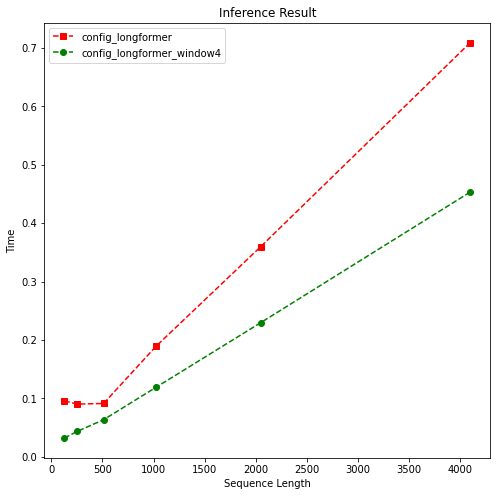

In [8]:
plotMe(results)

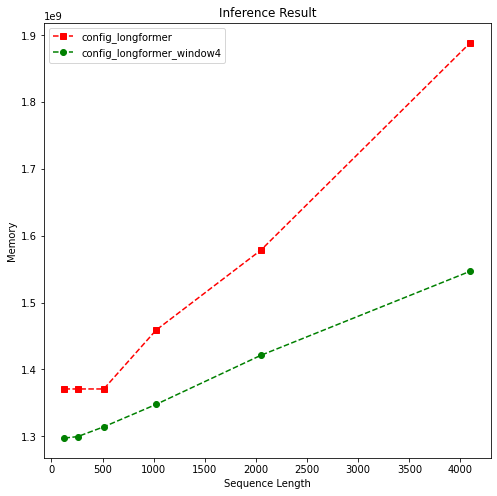

In [9]:
plotMe(results,"Memory")

# BigBird

In [10]:
from transformers import BigBirdConfig

# Default Bird  with num_random_blocks=3, block_size=64
sparseBird = BigBirdConfig.from_pretrained("google/bigbird-roberta-base")
# Fuyll attention Bird:
fullBird = BigBirdConfig.from_pretrained(
    "google/bigbird-roberta-base", 
    attention_type="original_full")

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [11]:
sequence_lengths=[256,512,1024,2048, 3072, 4096]
models=["sparseBird","fullBird"]
configs=[eval(m) for m in models]

In [12]:
from transformers import PyTorchBenchmark, PyTorchBenchmarkArguments

benchmark_args = PyTorchBenchmarkArguments(
    sequence_lengths=sequence_lengths,
    batch_sizes=[1],
    models=models)
benchmark = PyTorchBenchmark(
    configs=configs, 
    args=benchmark_args)
results = benchmark.run()

1 / 2


Attention type 'block_sparse' is not possible if sequence_length: 256 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
Attention type 'block_sparse' is not possible if sequence_length: 256 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buf

2 / 2

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
          sparseBird                 1              256             0.06     
          sparseBird                 1              512            0.093     
          sparseBird                 1              1024           0.247     
          sparseBird                 1              2048           0.484     
          sparseBird                 1              3072           0.722     
          sparseBird                 1              4096           0.964     
           fullBird                  1              256            0.047     
           fullBird                  1              512            0.075     
           fullBird                  1            

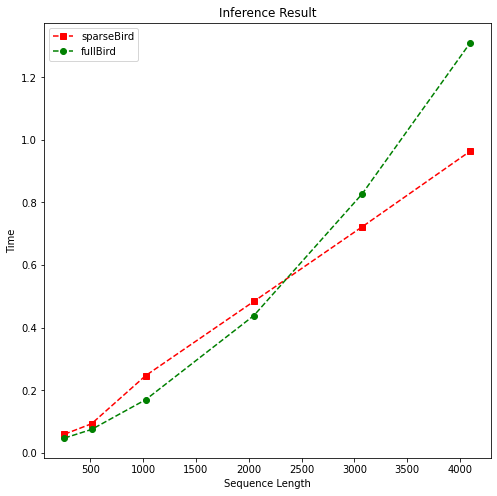

In [13]:
plotMe(results)

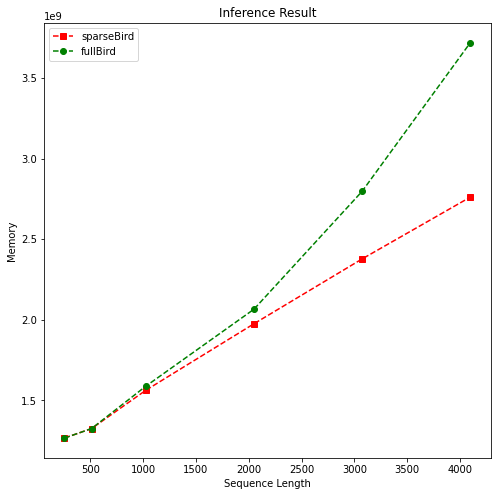

In [14]:
plotMe(results,"Memory")

# Reformer

In [15]:
from transformers import ReformerConfig, PyTorchBenchmark, PyTorchBenchmarkArguments

In [16]:
fullReformer = ReformerConfig.from_pretrained("google/reformer-enwik8",
                                               lsh_attn_chunk_length=16384, 
                                              local_attn_chunk_length=16384)
sparseReformer = ReformerConfig.from_pretrained("google/reformer-enwik8")

Downloading:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

In [17]:
sequence_lengths=[256, 512, 1024, 2048, 4096, 8192, 12000]
models=["fullReformer","sparseReformer"]
configs=[eval(e) for e in models]

In [18]:
from transformers import PyTorchBenchmark, PyTorchBenchmarkArguments

benchmark_args = PyTorchBenchmarkArguments(
    sequence_lengths=sequence_lengths,
    batch_sizes=[1],
    models=models)
benchmark = PyTorchBenchmark(
    configs=configs, 
    args=benchmark_args)
results = benchmark.run()

1 / 2
Doesn't fit on GPU. CUDA out of memory. Tried to allocate 4.29 GiB (GPU 0; 11.17 GiB total capacity; 9.37 GiB already allocated; 1.20 GiB free; 9.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Doesn't fit on GPU. CUDA out of memory. Tried to allocate 4.29 GiB (GPU 0; 11.17 GiB total capacity; 9.37 GiB already allocated; 1.20 GiB free; 9.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
2 / 2


/usr/local/lib/python3.7/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)
/usr/local/lib/python3.7/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)



====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
         fullReformer                1              256            0.067     
         fullReformer                1              512            0.129     
         fullReformer                1              1024           0.287     
         fullReformer                1              2048           0.679     
         fullReformer                1              4096           1.924     
         fullReformer                1              8192           6.438     
         fullReformer                1             12000            N/A      
        sparseReformer               1              256             0.07     
        sparseReformer               1              512 

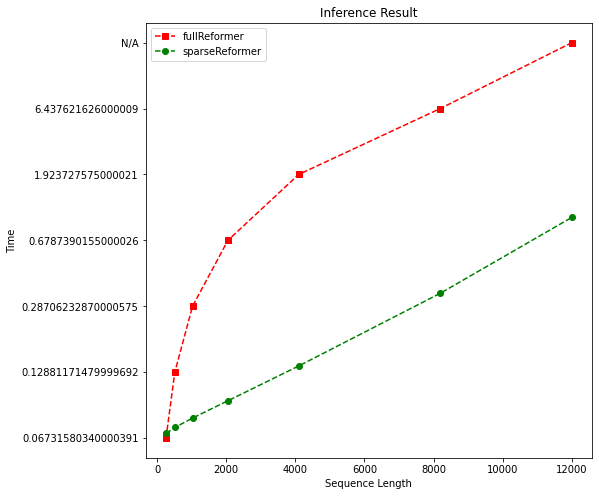

In [19]:
plotMe(results)

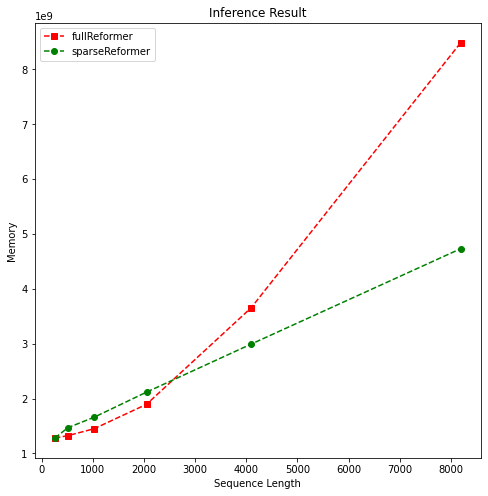

In [35]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
fmts= ["rs--","go--","b+-","c-o"]
q=results.memory_inference_result
models=list(q.keys())
seq=list(q[models[0]]['result'][1].keys())
models_perf=[list(q[m]['result'][1].values()) for m in models] 
#had to do this because of CUDA memory error
for j in models_perf:
    del j[6]
plt.xlabel('Sequence Length') 
plt.ylabel('Memory') 
plt.title('Inference Result') 
for perf,fmt in zip(models_perf,fmts):
    plt.plot(seq[:6], perf,fmt)
plt.legend(models)  
plt.show() 